In [1]:
# given accelerometer data on two subjects: .txt files in working dir
# subject walks a line, turns, walks back, several times
# filter the data, design algorithm to detect duration of each turn

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import glob

In [2]:
# define data class
class SubjectData:

    def __init__(self, name: str, data: np.ndarray, samp: int):
        self.name = name
        self.data = data
        self.samp = samp
        self.Ts = 1/self.samp
        self.N = len(self.data)
        self.t = np.linspace(0,self.N*self.Ts,self.N)

    def filter(self, impResp: np.ndarray):
        self.y = np.convolve(self.data,impResp,'same')

In [3]:
# get list of filenames
myFiles = sorted(glob.glob('*.txt'))
# given data sample rate
fs = 128

# populate object list
data = []
for item in myFiles:
    name = item.rsplit('.',1)[0]
    data.append(SubjectData(name, np.loadtxt(item), fs))

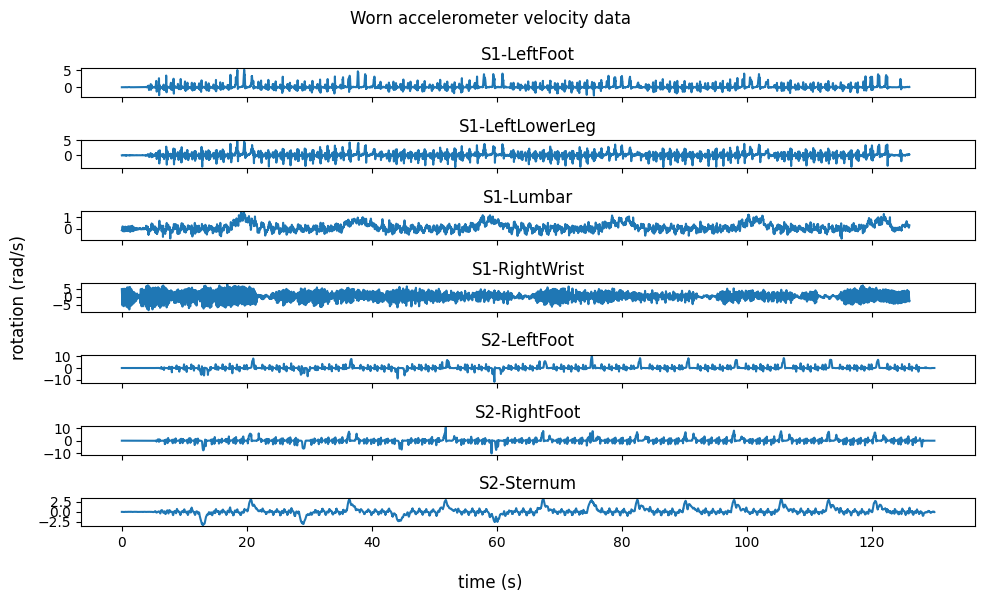

In [4]:
# plot raw data
fig, axs = plt.subplots(7,1,figsize=(10, 6), sharex=True)
for set,ax in zip(data,axs):
    ax.plot(set.t,set.data)
    ax.set_title(set.name)

# show plots
fig.suptitle('Worn accelerometer velocity data')
fig.supxlabel('time (s)')
fig.supylabel('rotation (rad/s)')
fig.tight_layout()
plt.show()

In [5]:
# use LPF with cutoff of 0.0005 Hz to detect slow turns only
h = signal.firwin(2001,cutoff=.0005,width=11,window='hamming',pass_zero='lowpass',fs=fs)

# filter each dataset using LPF defined above
for set in data:
    set.filter(h)

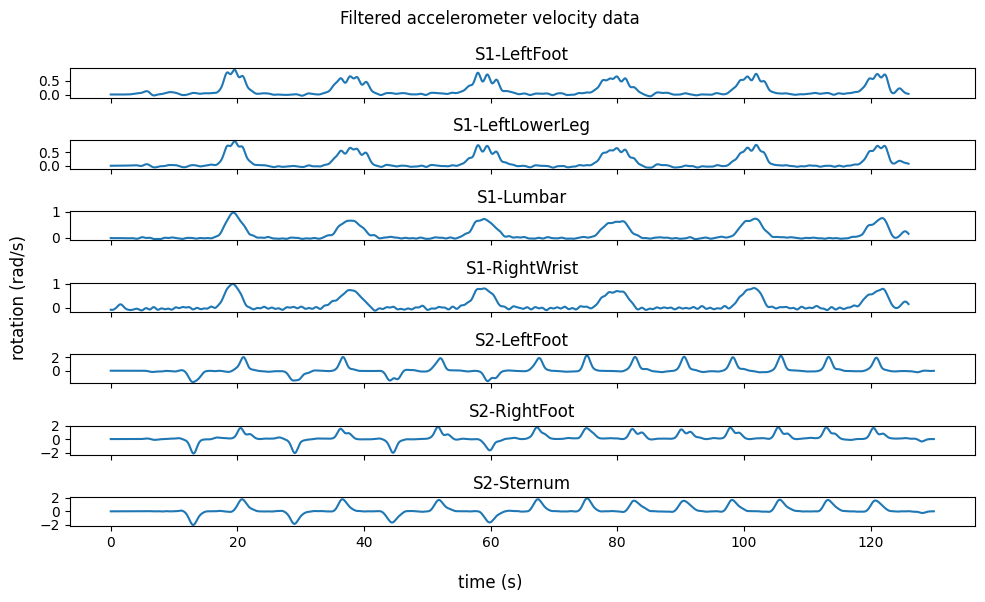

In [6]:
# plot filtered data
fig, axs = plt.subplots(7,1,figsize=(10, 6), sharex=True)
for set,ax in zip(data,axs):
    ax.plot(set.t,set.y)
    ax.set_title(set.name)

# show plots
fig.suptitle('Filtered accelerometer velocity data')
fig.supxlabel('time (s)')
fig.supylabel('rotation (rad/s)')
fig.tight_layout()
plt.show()

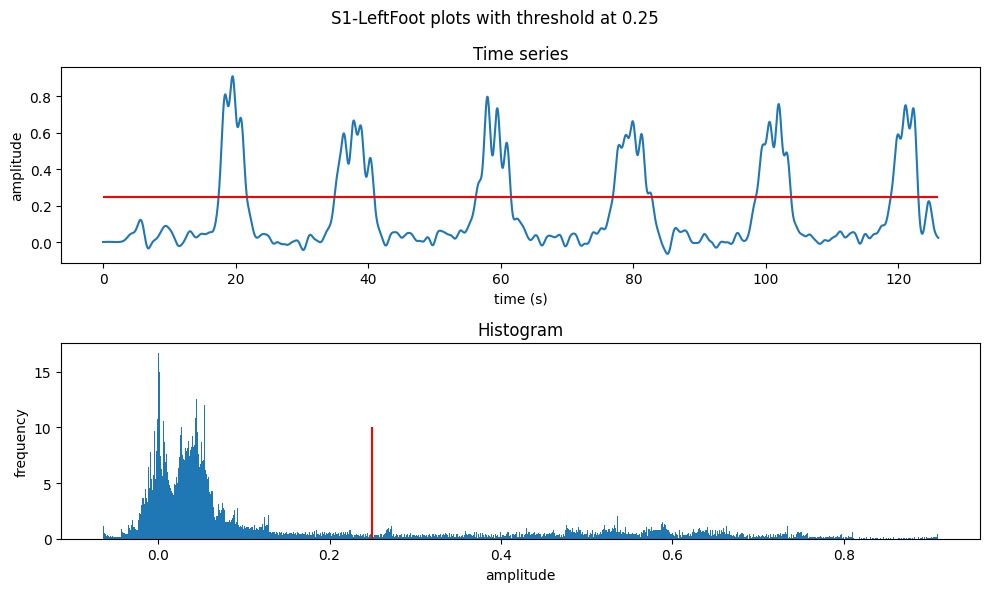

In [7]:
# test amplitude threshold on time series and histogram of data
# set threshold
thresh = 0.25
dset = data[0]
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6))
fig.suptitle(f'{dset.name} plots with threshold at {thresh}')
ax1.plot(dset.t, dset.y)
ax1.hlines(thresh,0,dset.N/fs,colors='r')
ax1.set_title('Time series')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude')

ax2.hist(dset.y,bins=1000,density=True,stacked=True)
ax2.vlines(thresh,0,10,colors='r')
ax2.set_title('Histogram')
ax2.set_ylabel('frequency')
ax2.set_xlabel('amplitude')

fig.tight_layout()

In [8]:
# define turn detection function
# find all points above a threshold, then
# find the min/max trigger point indexes between each gap in trig_index
# label those points in red/green on plot
def detectTurn(set,impResp,thresh):
    print(f"Detecting turns for {set.name}... ")

    # extract values for this set:
    try:
        y = set.y
    except:
        set.filter(impResp)
        y = set.y
    N = set.N
    t = set.t
    Ts = set.Ts

    # pick out the trigger points above amp threshold
    trig_threshold = thresh
    trig_index = []
    for x in range(N):
        if np.abs(y[x]) > trig_threshold:
            trig_index.append(x)
    if len(trig_index) < 20:
        print("Error: trigger index too low")
    
    # initialize start and end trigger point lists
    min = []
    max = []
    min.append(trig_index[0])

    # find start and end points for trigger index range between gaps
    for k in range(len(trig_index)):
        if k > 1 and k < len(trig_index)-1:
            if trig_index[k] != trig_index[k+1]-1:
                max.append(trig_index[k])
            if trig_index[k] != trig_index[k-1]+1:
                min.append(trig_index[k])
    max.append(trig_index[len(trig_index)-1])

    # find the average turn duration of all turns in set
    duration = []
    for p in range(len(min)):
        duration.append(max[p]-min[p])
    avg_dur = np.mean(duration)
    avg_turn_duration = avg_dur*Ts

    # plot values for validation
    fig= plt.figure(figsize=(14,5))
    plt.title(f'Trigger ranges for turn detection on {set.name}')
    plt.xlabel('time (s)')
    plt.ylabel('rotation (rad/s)')
    plt.plot(t,y)

    # plot red lines at start and green lines at end of each turn
    for m in min:
        plt.axvline(x=m*Ts, color='r')
    for n in max:
        plt.axvline(x=n*Ts, color='g')
        
    plt.show()

    return avg_turn_duration

Detecting turns for S1-LeftFoot... 


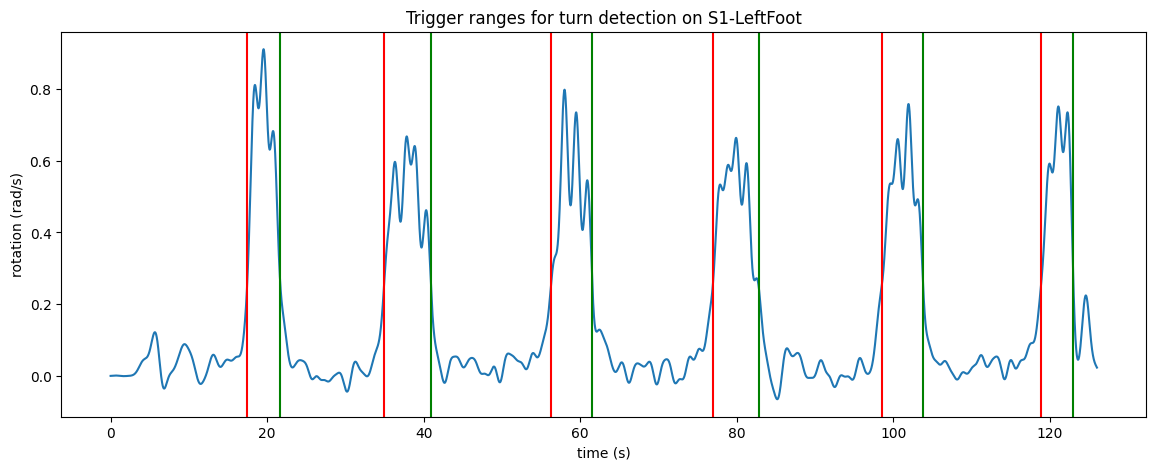

Average turn duration for S1-LeftFoot: 5.139 s
Detecting turns for S1-LeftLowerLeg... 


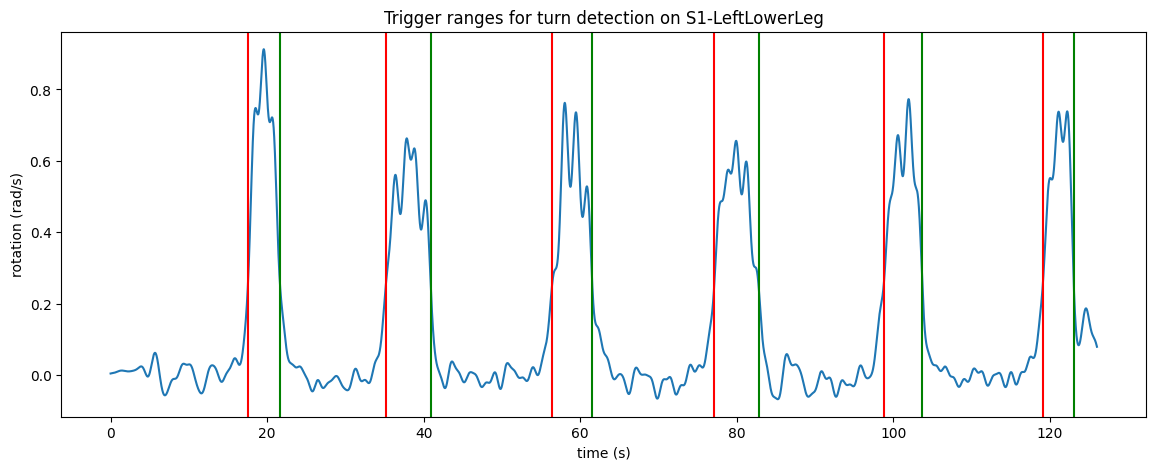

Average turn duration for S1-LeftLowerLeg: 4.926 s
Detecting turns for S1-Lumbar... 


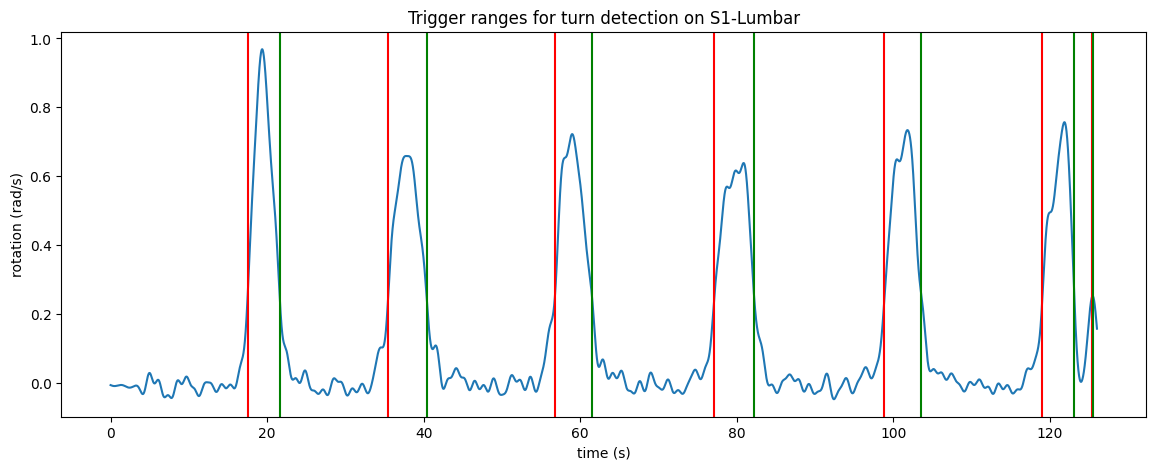

Average turn duration for S1-Lumbar: 3.965 s
Detecting turns for S1-RightWrist... 


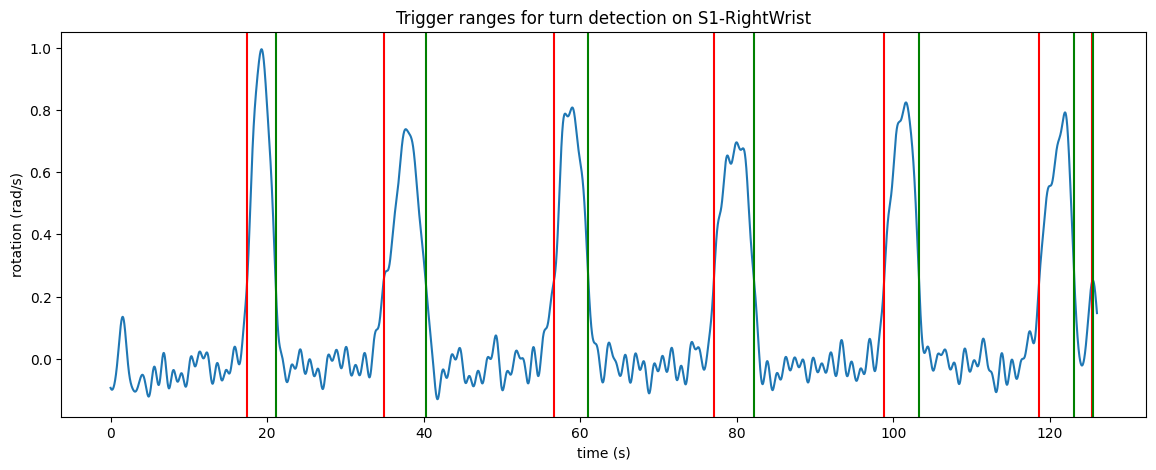

Average turn duration for S1-RightWrist: 3.939 s
Detecting turns for S2-LeftFoot... 


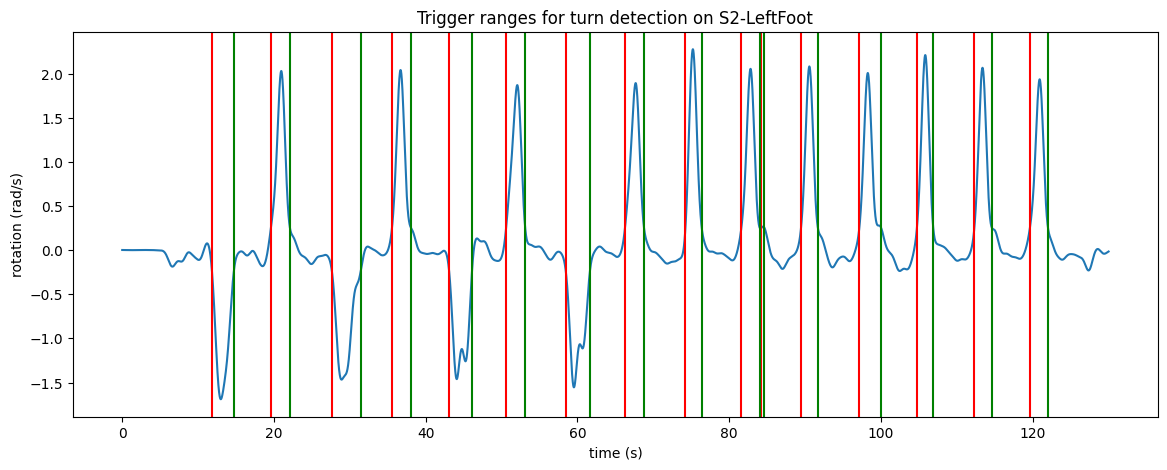

Average turn duration for S2-LeftFoot: 2.481 s
Detecting turns for S2-RightFoot... 


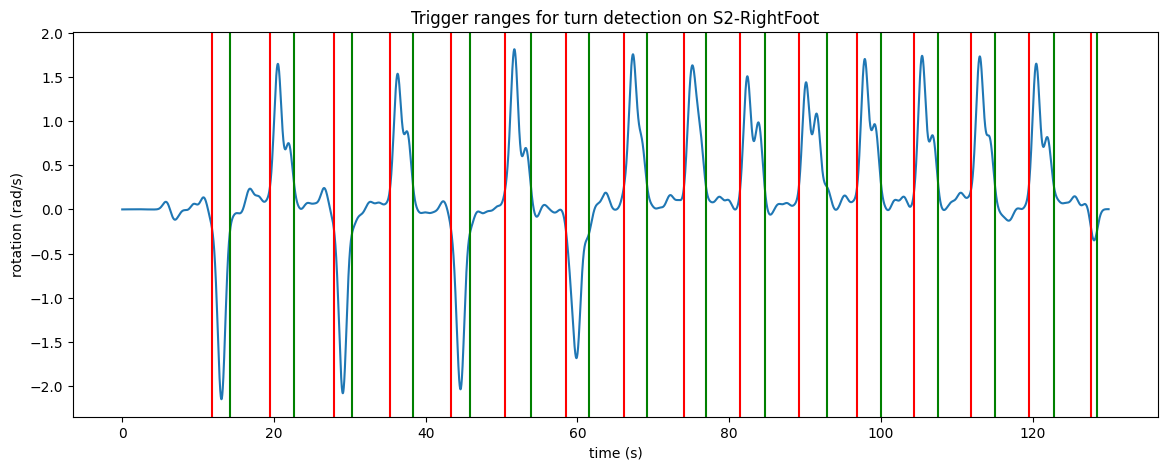

Average turn duration for S2-RightFoot: 2.898 s
Detecting turns for S2-Sternum... 


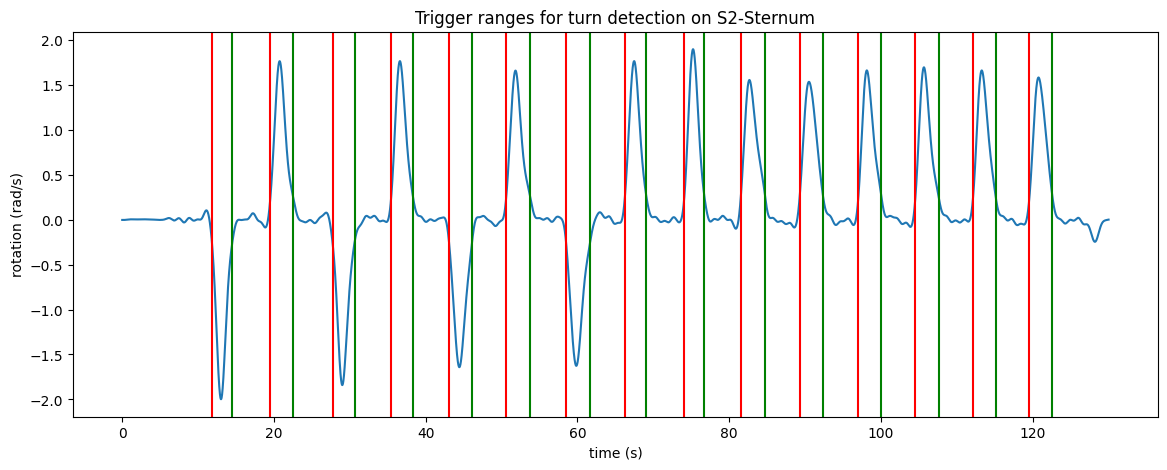

Average turn duration for S2-Sternum: 2.980 s


In [9]:
# detect turns on all sets
for set in data:
    print(f"Average turn duration for {set.name}: {detectTurn(set,h,thresh):.3f} s")